# Continuous Control

---

This notebook corresponds to the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program where the task is to solve the Reacher environment provided by Unity. The baseline of the code was provided by Udacity.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [2]:
# Change the file_name parameter to match the location of the Univy environment.
# We download the Unity environment with 20 agents.
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the agent

Run the code below to solve the environment. The environment is considered solved when it reaches an average score of `+30` in the last 100 episodes.  

In [5]:
seed_ = 7
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed_)

In [6]:
def ddpg(n_episodes=500, max_t=1000, learn_every=20, num_learning=10, goal=30.0):
    scores_window = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()                
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations   # get the next state
            reward = env_info.rewards                   # get the reward
            done = env_info.local_done                  # see if episode ha            
            
            for s, a, r, n_s, d in zip(state, action, reward, next_state, done):
                agent.add_memory(s, a, r, n_s, d)

            state = next_state
            score += env_info.rewards #reward

            if t % learn_every == 0:
                for _ in range(num_learning):
                    agent.step()
            
            if np.any(done):
                break 
                
        mean_score = np.mean(score)      
        scores_window.append(mean_score)
        scores.append(mean_score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window), mean_score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))   
        if np.mean(scores_window)>=goal and i_episode >= 120:
            print('\nEnvironment solved after {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores


In [7]:
scores = ddpg()

/mnt/data/home-efons/Virtualenvs/drlnd/deep-reinforcement-learning/p2_continuous-control/ddpg_agent.py:110: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 31.14	Score: 38.39
Episode 120	Average Score: 38.14	Score: 37.94
Environment solved after 120 episodes!	Average Score: 38.14


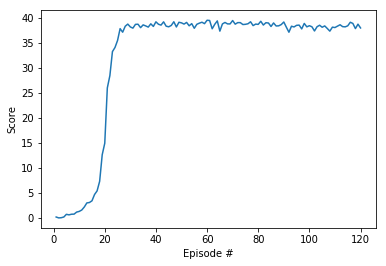

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
import pandas as pd
df_scores = pd.DataFrame(scores)

In [12]:
df_scores.to_csv('training_scores_per_episode.csv')